In [4]:
!python -V

Python 3.9.17


In [2]:
# Kaggle link data source: https://www.kaggle.com/datasets/iamsouravbanerjee/software-professional-salaries-2022?datasetId=2235743
import pandas as pd
df = pd.read_csv('data/Salary_Dataset.csv')

In [3]:
df.shape

(22770, 8)

In [4]:
df.nunique()

Rating                  41
Company Name         11260
Job Title             1080
Salary                 316
Salaries Reported       82
Location                10
Employment Status        4
Job Roles               11
dtype: int64

In [5]:
df.dtypes

Rating               float64
Company Name          object
Job Title             object
Salary                 int64
Salaries Reported      int64
Location              object
Employment Status     object
Job Roles             object
dtype: object

In [6]:
df.head()

,Rating,Company Name,Job Title,Salary,Salaries Reported,Location,Employment Status,Job Roles
0,3.8,Sasken,Android Developer,400000,3,Bangalore,Full Time,Android
1,4.5,Advanced Millennium Technologies,Android Developer,400000,3,Bangalore,Full Time,Android
2,4.0,Unacademy,Android Developer,1000000,3,Bangalore,Full Time,Android
3,3.8,SnapBizz Cloudtech,Android Developer,300000,3,Bangalore,Full Time,Android
4,4.4,Appoids Tech Solutions,Android Developer,600000,3,Bangalore,Full Time,Android


In [8]:
from sklearn.model_selection import train_test_split

#split the data into train and test set
train_val,test = train_test_split(df, test_size=0.20, random_state=42)
train,validation = train_test_split(train_val, test_size=0.25, random_state=42)
print(train.shape, validation.shape, test.shape)

#save the data
train.to_csv('data/salary_train.csv',index=False)
test.to_csv('data/salary_test.csv',index=False)
validation.to_csv('data/salary_validation.csv', index=False)


(13662, 8) (4554, 8) (4554, 8)


In [18]:
def read_dataframe(filename): 
    df = pd.read_csv(filename)
    categorical = ['Job Title', 'Location', 'Employment Status', 'Job Roles']
    df[categorical] = df[categorical].astype(str)

    return df    

In [17]:
df_train = read_dataframe('data/salary_train.csv')
df_val = read_dataframe('data/salary_validation.csv')

In [7]:
# features ['Job Title', 'Location', 'Employment Status','Job Roles','Rating']

In [11]:
y_train = df_train['Salary'].values
y_val = df_val['Salary'].values


In [13]:
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as pltm

# import warnings
# warnings.filterwarnings('ignore')

In [19]:
numerical = ['Rating']
categorical = ['Job Title', 'Location', 'Employment Status', 'Job Roles']
#df[categorical] = df[categorical].astype(str)
dv = DictVectorizer() 


train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
print(f'Train Feature matrix size: {X_train.shape}')

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)
print(f'Validation Feature matrix size: {X_val.shape}')

Train Feature matrix size: (13662, 864)
Validation Feature matrix size: (4554, 864)


In [20]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

print(f'Train RMSE: {mean_squared_error(y_val, y_pred, squared=False)}')

Train RMSE: 572517.4408615475


In [21]:
las = Lasso(0.01)
lasso_model  = las.fit(X_train, y_train)

y_pred_lasso = lasso_model.predict(X_val)

mean_squared_error(y_val, y_pred_lasso, squared=False)

/Users/rashmi/miniconda/envs/exp-track-env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5801754798862478.0, tolerance: 1411478799546.3872
  model = cd_fast.sparse_enet_coordinate_descent(


574745.1166716561

In [39]:
import mlflow 

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("salary-prediction-experiment")

<Experiment: artifact_location='/Users/rashmi/Documents/rashmi/github_repos/AtoZ_ml_ops_course/ds_salary_prediction/data-salary-prediction-mlops/01-model-dev-exp-tracking-mlflow/mlruns/1', creation_time=1692626512469, experiment_id='1', last_update_time=1692626512469, lifecycle_stage='active', name='salary-prediction-experiment', tags={}>

In [23]:
with mlflow.start_run():
    
    #mlflow
    mlflow.set_tag("developer", "rashmi")
    mlflow.log_param("train-data-path", "data/salary_train")
    mlflow.log_param("test-data-path", "data/salary_test")
    
    alpha = 0.01
    mlflow.log_param("alpha", alpha)

    ls = Lasso(alpha)
    lasso_model = ls.fit(X_train, y_train)
    y_pred_lasso = lasso_model.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred_lasso, squared=False)
    mlflow.log_metric("rmse", rmse)


/Users/rashmi/miniconda/envs/exp-track-env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5801754798862478.0, tolerance: 1411478799546.3872
  model = cd_fast.sparse_enet_coordinate_descent(


<Axes: ylabel='Count'>

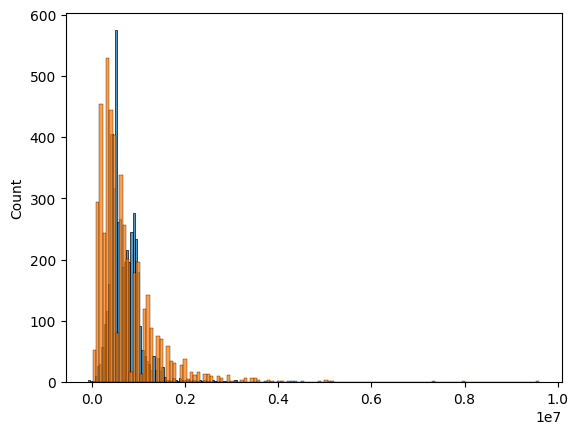

In [25]:
sns.histplot(y_pred_lasso, label='prediction')
sns.histplot(y_val, label='actual')

In [26]:
import xgboost as xgb

In [27]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [28]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [29]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [30]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=30,
    trials=Trials()
)

[16:07:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:812332.73500                      
[1]	validation-rmse:727156.73911                      
[2]	validation-rmse:672927.18270                      
[3]	validation-rmse:639379.08281                      
[4]	validation-rmse:621375.48507                      
[5]	validation-rmse:613822.12247                      
[6]	validation-rmse:611534.32813                      
[7]	validation-rmse:612097.27984                      
[8]	validation-rmse:614115.08883                      
[9]	validation-rmse:616659.41186                      
[10]	validation-rmse:620421.17476                     
[11]	validation-rmse:622952.10092                     
[12]	validation-rmse:625772.52093                     
[13]	validation-rmse:627773.66887                     
[14]	validation

In [1]:
import pickle

In [34]:
with mlflow.start_run():
    best_params = {
        'learning_rate': 0.08602429724586722,
        'max_depth': 4, 
        'min_child_weight': 0.897422547369506, 
        'objective': 'reg:linear',
        'reg_alpha': 0.0240476290600817,
        'reg_lambda': 0.03149828700671684,
        'seed' : 42
        }
    
    mlflow.log_params(best_params)

    booster = xgb.train(
        params = best_params, 
        dtrain=train, 
        num_boost_round = 1000, 
        evals = [(valid, "validation")], 
        early_stopping_rounds = 20
        )  

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse) 
    
    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)

    mlflow.log_artifact("models/preprocessor.b", artifact_path = "preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path = "models_mlflow")

[12:33:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:893326.38682
[1]	validation-rmse:852511.84462
[2]	validation-rmse:816952.50404
[3]	validation-rmse:785643.63467
[4]	validation-rmse:759091.08393
[5]	validation-rmse:734842.61476
[6]	validation-rmse:715491.42502
[7]	validation-rmse:698138.52607
[8]	validation-rmse:682628.81065
[9]	validation-rmse:670209.93218
[10]	validation-rmse:659277.47859
[11]	validation-rmse:650446.27787
[12]	validation-rmse:642551.86428
[13]	validation-rmse:635543.03604
[14]	validation-rmse:630322.58100
[15]	validation-rmse:625706.35314
[16]	validation-rmse:621700.44698
[17]	validation-rmse:618765.99768
[18]	validation-rmse:615389.28063
[19]	validation-rmse:612673.03302
[20]	validation-rmse:610782.46919
[21]	validation-rmse:609090.54719
[22]	validation-rmse:607889.71402
[23]	validati

In [2]:
from mlflow.tracking import MlflowClient 

In [3]:
MLFLOW_TRACKING_URI = 'http://127.0.0.1:5000'
RUN_ID = '7ff20c8c0dc24ed0b0cbca764d81bacd'
client = MlflowClient(tracking_uri = MLFLOW_TRACKING_URI)

In [4]:
path = client.download_artifacts(run_id=RUN_ID, path ='/Users/rashmi/Documents/rashmi/github_repos/AtoZ_ml_ops_course/ds_salary_prediction/data-salary-prediction-mlops/02-workflow-orchestration/prefect-mlops-zoomcamp/mlruns/1/7ff20c8c0dc24ed0b0cbca764d81bacd/artifacts/preprocessor/preprocessor.b')

In [5]:
import pickle
with open(path, "rb") as f_out:
    dv = pickle.load(f_out)

print(dv)

DictVectorizer()


In [6]:
import mlflow

MLFLOW_TRACKING_URI = "http://127.0.0.1:5000"
RUN_ID = "7ff20c8c0dc24ed0b0cbca764d81bacd"

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)
mlflow.set_experiment("salary-predictor-exp")


logged_model = f"runs:/{RUN_ID}/models_mlflow"

loaded_model = mlflow.pyfunc.load_model(logged_model)

#print(model)

[13:52:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [7]:
print(logged_model)

runs:/7ff20c8c0dc24ed0b0cbca764d81bacd/models_mlflow


In [8]:
print(loaded_model)

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 7ff20c8c0dc24ed0b0cbca764d81bacd



In [34]:
salary_features = {
    "Rating": 3.2,
    "Job Title": "Android Developer",
    "Location": "Bangalore",
    "Employment Status": "Full Time",
    "Job Roles": "Android",
}

In [35]:
def prepare_sal_features(salary_features):
    fea = {}
    fea["Rating"] = salary_features["Rating"]
    fea["Job Title"] = salary_features["Job Title"]
    fea["Location"] = salary_features["Location"]
    fea["Employment Status"] = salary_features["Employment Status"]
    fea["Job Roles"] = salary_features["Job Roles"]
    return fea

In [36]:
print(type(salary_features))
new_features = prepare_sal_features(salary_features)
print(type(new_features))

<class 'dict'>
<class 'dict'>


In [38]:
import xgboost as xgb
X_test = dv.transform(new_features)
print(X_test)
dmatrix = xgb.DMatrix(X_test)
print(dmatrix)
preds = loaded_model.predict(X_test)
print(preds)

  (0, 1)	1.0
  (0, 4)	1.0
  (0, 37)	1.0
  (0, 853)	1.0
  (0, 863)	3.2
[655947.5]


In [33]:
type(features)

dict

In [16]:
print(float(preds[0]))

655947.5
